# HPC PROJECT PART 2

Tanner Salvage

This program solves the diffusion equation with forward and centred difference discretisations. It uses an OpenCL and NumPy implementation to solve the equation and experiments with time steps and intial conditions to evaluate the effect on the solution.

In [1]:
# Initialise
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl
import os
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

In [2]:
# OpenCL initialisation
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

kernel = """

 __kernel void SolveDiffusionEqn(__global double *result,
                                 __global double *u_n,
                                 __global double *sigma,
                                 double dt,
                                 int N)
{

    // Initialise
    int gid = get_global_id(0);
    float h = 1.0/N;

    
    if(gid < N|| gid % N == 0||(gid+1) % N == 0||gid > (N * N - N))
        // Dont compute on the boundaries
        result[gid] = u_n[gid];
    else    
        // Forward Euler with centred difference approximation
        result[gid] = u_n[gid] + dt/(2*h*h) *( 
                     (sigma[gid+1] + sigma[gid]) * (u_n[gid+1] - u_n[gid]) -
                     (sigma[gid-1] + sigma[gid]) * (u_n[gid] - u_n[gid-1]) + 
                     (sigma[gid+N] + sigma[gid]) * (u_n[gid+N] - u_n[gid]) -
                     (sigma[gid-N] + sigma[gid]) * (u_n[gid] - u_n[gid-N]));

}

"""
# build the kernel
prg = cl.Program(ctx, kernel).build()
kernel = prg.SolveDiffusionEqn

def solve_diffusion_eqn(u_n, sigma, dt, N):

    """
    Solves a 2d diffusion equation with OpenCL.

    This function solves the 2d time dependant 
    diffusion equation with zero boundary conditions
    and intial condition u_n. 
    
    The x and y domains are the interval [0, 1]
    and sigma is an operator acting on u_n.
    """
   
    # Create buffers for kernel
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR | mf.WRITE_ONLY, size=len(u_n) * 8)
    u_n_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=u_n)
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    
    # Compute result with kernel
    kernel(queue, (N*N, ), (1, ), result_buffer, u_n_buffer, sigma_buffer, np.float64(dt), np.int32(N)) 
    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                  0, (N*N, ), np.double)
    
    return result

In [3]:
def solve_diffusion_eqn_numpy(u_n, sigma, dt, N):
    """
    Solves a 2d diffusion equation with NumPy.

    This function solves the 2d time dependant 
    diffusion equation using a NumPy implementation
    with zero boundary conditions and intial 
    condition u_n. 
    
    The x and y domains are the interval [0, 1]
    and sigma is an operator acting on u_n.
    """
     
    # Initialisation
    result = np.zeros((N, N))
    h = 1.0/N
    
    # Forward Euler with centred difference approximation computed only on inner grid
    result[1:-1, 1:-1] = u_n[1:-1, 1:-1] +  (dt/(2*h**2)) * (
                    (sigma[2:, 1:-1] + sigma[1:-1, 1:-1])* (u_n[2:, 1:-1] - u_n[1:-1, 1:-1])-
                    (sigma[:-2, 1:-1]+ sigma[1:-1, 1:-1])* (u_n[1:-1, 1:-1]- u_n[:-2, 1:-1])+
                    (sigma[1:-1, 2:] + sigma[1:-1, 1:-1])* (u_n[1:-1, 2:] - u_n[1:-1, 1:-1])-
                    (sigma[1:-1, :-2]+ sigma[1:-1, 1:-1])* (u_n[1:-1, 1:-1] - u_n[1:-1, :-2]))
   
    return result

In [4]:
def create_initial_condition(N):
    """
    Initialises the 2d diffusion problem.

    This function creates the initial condition
    vector u_n with zero boundary conditions and
    a source point.
    """
    
    # Initialisation
    dx = dy = 1.0/N
    u_n = np.zeros((N* N)) 
    temp = 100

    # Initial condition - source point with specified radius and centre
    radius, centre = 0.2, 0.5
    for i in range(N):
        for j in range(N):
            circle = (i*dx - centre)**2 + (j*dy - centre)**2
            if circle <= radius**2:
                u_n[i*N+j] = temp

    # Create Gaussian normal operator, sigma 
    mean, stdev = 0.0, 0.01
    sigma = np.exp(-(np.random.normal(mean, stdev, ((N) * (N)))))
    
    return(u_n, sigma)

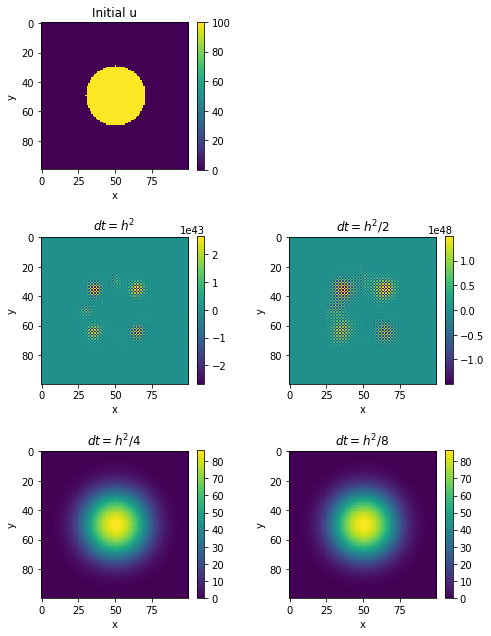

In [5]:
# Experiment 1 - effect of time step

# Initialise
N = 100
h = 1.0/N
(u_n, sigma) = create_initial_condition(N)
final_time = 0.005
index = 0


# Vector of time steps and corresponding graph titles
dtVec = [h**2, (h**2)/2, (h**2)/4, (h**2)/8] 
title_vec=["$dt = {h^2}$", "$dt = {h^2}/2 $", 
           '$dt = {h^2}/4$', '$dt = {h^2}/8$'] 


# Plot initial condition
un = np.resize(u_n, (N,N))
plt.subplot(3, 2, 1)
plt.imshow(un)
plt.title('Initial u')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')


# Solve equation with time steps in dtVec
for dt in dtVec:   
    
    # Reset u_new to initial condition
    u_new = u_n
    nsteps = int(final_time/dt)
    
    for step in range(nsteps +1):
        u_new = solve_diffusion_eqn(u_new, sigma, dt, N)
        
    # Plot the solution
    un = np.resize(u_new, (N,N))
    plt.subplot(3, 2, index +3)
    plt.imshow(un)
    plt.title(title_vec[index])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.subplots_adjust(top=2, bottom=0.0, left=0, right=1, hspace=0.45,
                    wspace=0.35)
    index += 1

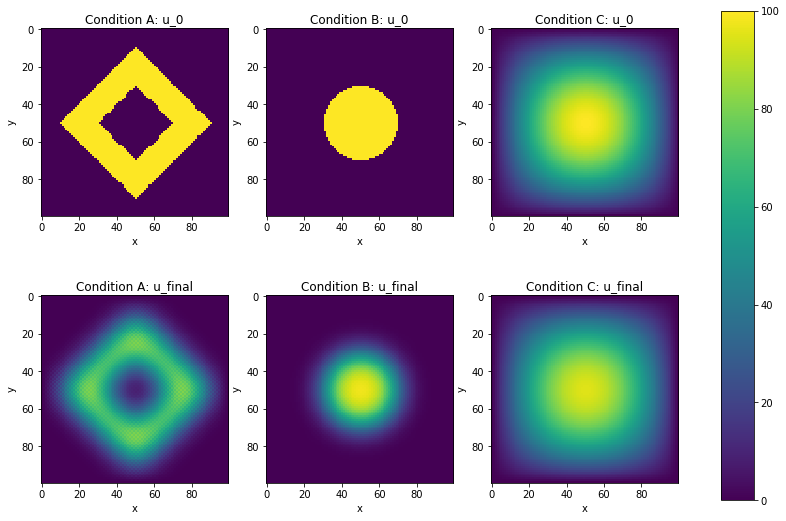

max temperature A: 81.18901610054453
max temperature B: 97.88389604581253
max temperature C: 95.18453546271635


In [6]:
# Experiment 2 - effect of initial condition

# Initialise
N = 100
h = 1.0/N
dt = (h**2)/4
nsteps = 100
temp = 100
u_n_A = np.zeros((N* N)) 
u_n_B = np.zeros((N* N)) 
u_n_C = np.zeros((N* N)) 
pi = np.pi
x = y = np.arange(0, 1+h, h)


# Initial condition A - diamond shaped heat source 
diamond_radius, centre, width = 0.4, 0.5, 0.2
for i in range(1, N):
    for j in range(1, N):
        diamond = np.abs(x[i] - centre) + np.abs(y[j] - centre)
        if ((diamond_radius - width) <= diamond <= diamond_radius):
            u_n_A[i*N+j] = temp
            
            
# Initial condition B - source point with same area as condition A
# Compute squared radius
circle_radius2 = (diamond_radius**2 - width**2)/pi
centre = 0.5
for i in range(N):
    for j in range(N):
        circle = (x[i] - centre)**2 + (y[j] - centre)**2
        if circle <= circle_radius2:
            u_n_B[i*N+j] = temp
            

# Initial condition C - temperature gradient with weight in the centre
for i in range(1, N-1):
    for j in range(1, N-1):
        u_n_C[i*N+j] = temp*np.sin(pi*x[i])*np.sin(pi*y[j])


# Plot initial solutions
u_new_A = u_n_A
unA = np.resize(u_new_A, (N,N))
plt.subplot(231)
plt.imshow(unA, vmin=0, vmax = 100)
plt.title('Condition A: u_0')
plt.xlabel('x')
plt.ylabel('y')

u_new_B = u_n_B
unB = np.resize(u_new_B, (N,N))
plt.subplot(232)
plt.imshow(unB, vmin=0, vmax = 100)
plt.title('Condition B: u_0')
plt.xlabel('x')
plt.ylabel('y')

u_new_C = u_n_C
unC = np.resize(u_new_C, (N,N))
plt.subplot(233)
plt.imshow(unC, vmin=0, vmax = 100)
plt.title('Condition C: u_0')
plt.xlabel('x')
plt.ylabel('y')

# Solve for all initial conditions 
for step in range(nsteps):
    u_new_A = solve_diffusion_eqn(u_new_A, sigma, dt, N)
    u_new_B = solve_diffusion_eqn(u_new_B, sigma, dt, N)
    u_new_C = solve_diffusion_eqn(u_new_C, sigma, dt, N)
    
# Resize for plotting
unA = np.resize(u_new_A, (N,N))
unB = np.resize(u_new_B, (N,N))
unC = np.resize(u_new_C, (N,N))

# Plot solutions
plt.subplot(234)
plt.imshow(unA, vmin=0, vmax = 100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condition A: u_final')

plt.subplot(235)
plt.imshow(unB, vmin=0, vmax = 100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condition B: u_final')

plt.subplot(236)
plt.imshow(unC, vmin=0, vmax = 100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condition C: u_final')

plt.subplots_adjust(bottom=0.0, right=1.6, top=1.7)
cax = plt.axes([1.7, 0.0, 0.075, 1.7])
cbar = plt.colorbar(cax=cax)
plt.show()

print('max temperature A:', max(u_new_A))
print('max temperature B:', max(u_new_B))
print('max temperature C:', max(u_new_C))

Time with Numpy: 0.0031061172485351562 s


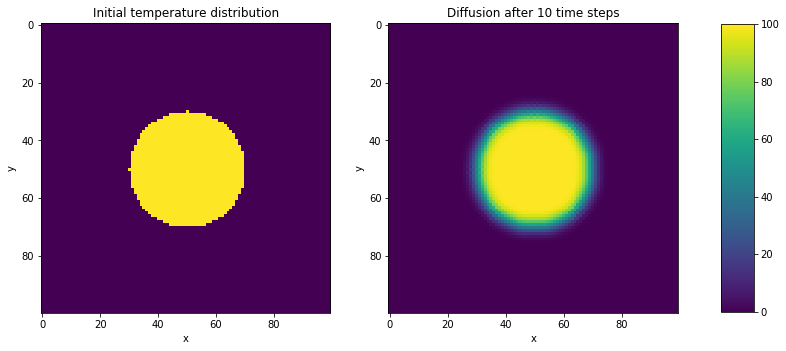

In [7]:
# Experiment 3 - Numpy performance

# Initialise
N = 100
h = 1.0/N
dt = (h**2)/4
(u_n, sigma) = create_initial_condition(N)
u_new = np.resize(u_n, (N,N))
sigma = np.resize(sigma, (N,N))
nsteps = 10

# Plot initial condition
plt.subplot(121)
plt.imshow(u_new)
plt.title('Initial temperature distribution')
plt.xlabel('x')
plt.ylabel('y')

# Time the solution
import time
start = time.time()

# solve for 10 time steps using Numpy
for step in range(nsteps):
    u_new = solve_diffusion_eqn_numpy(u_new, sigma, dt, N)

# Calculate total time
end = time.time()
total_time =  end - start

# plot the solution
plt.subplot(122)
plt.imshow(u_new)
plt.title('Diffusion after 10 time steps')
plt.xlabel('x')
plt.ylabel('y')

plt.subplots_adjust(bottom=0.1, right=1.6, top=1.7)
cax = plt.axes([1.7, 0.4, 0.075, 1])
plt.colorbar(cax=cax)
print('Time with Numpy:', total_time, 's')

time with OpenCL: 0.007410287857055664 s


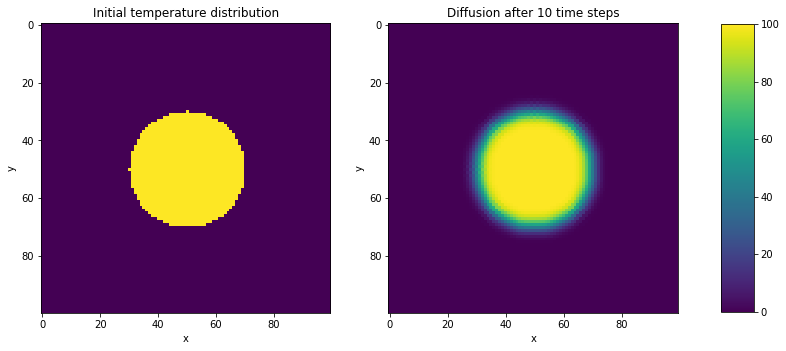

In [8]:
# Experiment 3 - OpenCL Performance

# Initialise
N = 100
h = 1.0/N
dt = (h**2)/4
nsteps = 10
(u_new, sigma) = create_initial_condition(N)

# Plot initial distribution            
un = np.resize(u_new, (N,N))
plt.subplot(121)
plt.imshow(un)
plt.title('Initial temperature distribution')
plt.xlabel('x')
plt.ylabel('y')


# Time the solution
import time
start = time.time()

# Solve for 10 time steps
for step in range(nsteps):
    u_new = solve_diffusion_eqn(u_new, sigma, dt, N)

# Compute total time    
end = time.time()
total_time =  end - start


# Plot the solution
un = np.resize(u_new, (N,N))
plt.subplot(122)
plt.imshow(un)
plt.title('Diffusion after 10 time steps')
plt.xlabel('x')
plt.ylabel('y')

plt.subplots_adjust(bottom=0.1, right=1.6, top=1.7)
cax = plt.axes([1.7, 0.4, 0.075, 1])
plt.colorbar(cax=cax)
print('time with OpenCL:', total_time, 's')